# Calculate response spectra
eqsig uses the Nigam and Jennings (1968) algorithm to compute the spectral acceleration.
However, it does not enforce integration interval <= Period/20 if the ground motion time step is considerably larger
than this limit, 1) to avoid excessive computation; 2) the record is probably missing frequency content that would
influence the response.

Therefore the solution is less accurate at very low periods if the time step is large. However, you can change the limit
for the ratio of ground motion time step over integration time step using the parameter `min_dt_ratio`, which defaults
to 4.

This example demonstrates these aspects of the algorithm.

In [1]:
import numpy as np
import eqsig
import matplotlib.pyplot as plt
from tests.conftest import TEST_DATA_DIR


## Load time history analysis solution

In [2]:

test_filename = 'test_motion_true_spectra_acc.csv'
data = np.loadtxt(TEST_DATA_DIR + test_filename, skiprows=1, delimiter=",")
periods = data[:, 0]
ss_s_a = data[:, 1]


## Load ground motion and compute response spectrum for same periods

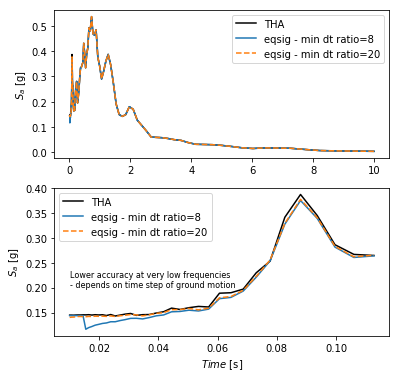

In [3]:
record_filename = 'test_motion_dt0p01.txt'
asig = eqsig.load_asig('test_motion_dt0p01.txt')  # fast load for eqsig format

bf, sps = plt.subplots(nrows=2, figsize=(6, 6))
# plot THA
sps[0].plot(periods, ss_s_a, label="THA", c='k')
sps[1].plot(periods[:40], ss_s_a[:40], label="THA", c='k')

# plot response spectrum using default ratio on dt
asig.generate_response_spectrum(response_times=periods, xi=0.05)
sps[0].plot(periods, asig.s_a / 9.81, label="eqsig - min dt ratio=8")
sps[1].plot(periods[:40], asig.s_a[:40] / 9.81, label="eqsig - min dt ratio=8")

# Plot response spectrum using lower ratio on dt (slower computation)
asig.generate_response_spectrum(response_times=periods, xi=0.05, min_dt_ratio=20)
sps[0].plot(periods, asig.s_a / 9.81, ls='--', label="eqsig - min dt ratio=20")
sps[1].plot(periods[:40], asig.s_a[:40] / 9.81, ls='--', label="eqsig - min dt ratio=20")

sps[1].text(0.01, 0.2, 'Lower accuracy at very low frequencies \n- depends on time step of ground motion', size=8)
sps[0].legend()
sps[1].legend()
sps[0].set_ylabel('$S_a$ [g]')
sps[1].set_ylabel('$S_a$ [g]')
sps[1].set_xlabel('$Time$ [s]')
plt.show()
